In [1]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import os
import cv2
from google.colab import drive
drive.mount('/content/drive')
import shutil
import matplotlib.pyplot as plt
import sys
from collections import Counter
import re
sys.path.append('/content/drive/MyDrive/ABELE_prostate/claudio/black_box/code/IGTD/Scripts')
import IGTD_Functions_original as IGTD
from scipy.stats import spearmanr, rankdata
from scipy.spatial.distance import pdist, squareform
import time
import _pickle as cp
from astropy.stats import median_absolute_deviation

Mounted at /content/drive


In [ ]:
num_row = 30     # Number of pixel rows in image representation
num_col = 30   # Number of pixel columns in image representation
num = num_row * num_col # Number of features to be included for analysis, which is also the total number of pixels in image representation
save_image_size = 3 #3 # Size of pictures (in inches) saved during the execution of IGTD algorithm.
max_step = 10 #10000    # The maximum number of iterations to run the IGTD algorithm, if it does not converge.
val_step = 100 #300  # The number of iterations for determining algorithm convergence. If the error reduction rate
                # is smaller than a pre-set threshold for val_step itertions, the algorithm converges.
table = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/code/IGTD/Data/Example_Gene_Expression_Tabular_Data.txt'

# Import the example data and linearly scale each feature so that its minimum and maximum values are 0 and 1, respectively.
data = pd.read_csv(table, low_memory=False, sep='\t', engine='c',
                   na_values=['na', '-', ''], header=0, index_col=0)

# Select features with large variations across samples
id = IGTD.select_features_by_variation(data, variation_measure='var', num=num)
data = data.iloc[:, id]

# Perform min-max transformation so that the maximum and minimum values of every feature become 1 and 0, respectively.
norm_data = IGTD.min_max_transform(data.values)
norm_data = pd.DataFrame(norm_data, columns=data.columns, index=data.index)
norm_data

,A2ML1,ABCA3,ABCC3,ABO,ACP5,ACSL5,ADAM8,ADAMTS1,ADM,ADM2,...,VIM,WFDC2,WNK4,WNT5A,YBX2,ZBED2,ZG16B,ZNF703,ZNF750,ZNF853
CCL_100,0.004091,0.584926,0.831278,0.603603,0.014991,0.951504,0.586766,0.004407,0.368580,0.706956,...,0.796291,0.823980,0.742799,0.000000,0.068633,0.503608,0.982094,0.696504,0.011548,0.007984
CCL_1000,0.031288,0.841432,0.369475,0.013115,0.085299,0.015608,0.223864,0.013383,0.564680,0.563872,...,0.055929,0.025829,0.375632,0.020670,0.923539,0.001654,0.738126,0.633798,0.428559,0.205988
CCL_1001,0.014950,0.036652,0.739522,0.646079,0.032655,0.932645,0.230116,0.134976,0.550398,0.351865,...,0.000000,0.031994,0.459353,0.001160,0.526670,0.488824,0.135369,0.711266,0.037850,0.011776
CCL_1002,0.000000,0.067849,0.841865,0.000000,0.014991,0.484329,0.147886,0.509385,0.997803,0.005190,...,0.850321,0.031994,0.115544,0.878004,0.010668,0.019586,0.070795,0.494922,0.006622,0.548303
CCL_1003,0.000000,0.017647,0.072094,0.000000,0.351307,0.555456,0.282211,0.056471,0.150233,0.032726,...,0.568487,0.051658,0.017348,0.014918,0.015238,0.174242,0.004723,0.008030,0.102222,0.312774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCL_127,0.004091,0.137039,0.018922,0.000000,0.713655,0.005173,0.080884,0.534846,0.770667,0.427664,...,0.937208,0.019664,0.719572,0.053870,0.091571,0.045599,0.009457,0.309046,0.024712,0.007984
CCL_129,0.008155,0.371726,0.022452,0.000000,0.187217,0.603592,0.412368,0.022360,0.095303,0.962346,...,0.042786,0.044218,0.144452,0.058512,0.108320,0.026100,0.124289,0.123170,0.029683,0.085230
CCL_130,0.062531,0.893900,0.037795,0.000000,0.074840,0.032420,0.118873,0.245144,0.199121,0.760162,...,0.762704,0.045387,0.410275,0.425825,0.551247,0.009793,0.039348,0.966344,0.009924,0.831337
CCL_131,0.001352,0.185842,0.747252,0.034353,0.168390,0.382128,0.155580,0.571242,0.537215,0.377896,...,0.859083,0.014668,0.252805,0.073595,0.036665,0.215084,0.066095,0.437766,0.011548,0.110778


In [ ]:
# Run the IGTD algorithm using (1) the Euclidean distance for calculating pairwise feature distances and pariwise pixel
# distances and (2) the absolute function for evaluating the difference between the feature distance ranking matrix and
# the pixel distance ranking matrix. Save the result in test1 folder.
fea_dist_method = 'Euclidean'
image_dist_method = 'Euclidean'
error = 'abs'
result_dir = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/code/IGTD/test/test1/'
os.makedirs(name=result_dir, exist_ok=True)
IGTD.table_to_image(norm_data, [num_row, num_col], fea_dist_method, image_dist_method, save_image_size,
               max_step, val_step, result_dir, error)

Step 0 err: 54468446060.0
Step 1 err: 54426454303.0
Step 2 err: 54394706565.0
Step 3 err: 54360094753.0
Step 4 err: 54322310939.0
Step 5 err: 54241661246.0
Step 6 err: 54156332701.0
Step 7 err: 54128149344.0
Step 8 err: 54067538112.0
Step 9 err: 53993802876.0


/content/drive/MyDrive/ABELE_prostate/claudio/black_box/code/IGTD/Scripts/IGTD_Functions_original.py:357: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  pd.DataFrame(index_record).to_csv(save_folder + '/' + file_name + '_index.txt', header=False, index=False,
/content/drive/MyDrive/ABELE_prostate/claudio/black_box/code/IGTD/Scripts/IGTD_Functions_original.py:359: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  pd.DataFrame(np.transpose(np.vstack((err_record, np.array(range(s + 2))))),
/content/drive/MyDrive/ABELE_prostate/claudio/black_box/code/IGTD/Scripts/IGTD_Functions_original.py:362: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  pd.DataFrame(np.transpose(np.vstack((err_record, run_time))), columns=['error', 'run_time']).to_csv(
/content/drive/MyDrive/ABELE_prostate/claudio/black_box/code/IGTD/Scripts/IGTD_Functions_original.py:616: FutureWarning

(396, 393)


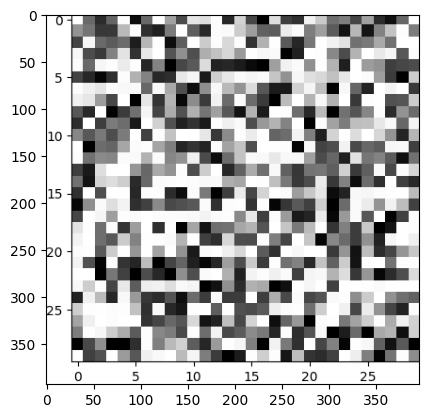

In [ ]:
from PIL import Image
img = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/code/IGTD/test/test1/data/_CCL_100_image.png'
img = Image.open(img)
print(img.size)
plt.imshow(img)

In [ ]:
import cv2
img = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/code/IGTD/test/test1/data/_CCL_100_image.png'
img = cv2.imread(img)
print(img.shape)

(393, 396, 3)


In [ ]:
# Run the IGTD algorithm using (1) the Pearson correlation coefficient for calculating pairwise feature distances,
# (2) the Manhattan distance for calculating pariwise pixel distances, and (3) the square function for evaluating
# the difference between the feature distance ranking matrix and the pixel distance ranking matrix.
# Save the result in test2 folder.
fea_dist_method = 'Pearson'
image_dist_method = 'Manhattan'
error = 'squared'
norm_data = norm_data.iloc[:, :800]
result_dir = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/code/IGTD/test2/'
os.makedirs(name=result_dir, exist_ok=True)
IGTD.table_to_image(norm_data, [num_row, num_col], fea_dist_method, image_dist_method, save_image_size,
               max_step, val_step, result_dir, error)

Step 0 err: 5348940322482732.0
Step 1 err: 5327929445486217.0
Step 2 err: 5321922459370561.0
Step 3 err: 5307617009638945.0
Step 4 err: 5297244978689052.0
Step 5 err: 5281633162893267.0
Step 6 err: 5269736593779117.0
Step 7 err: 5262974632637157.0
Step 8 err: 5255951803537721.0
Step 9 err: 5249306083942330.0
Step 10 err: 5239544714181439.0
Step 11 err: 5227793392641237.0
Step 12 err: 5217280122989494.0
Step 13 err: 5212859236699192.0
Step 14 err: 5205532543759564.0
Step 15 err: 5201648614224013.0
Step 16 err: 5192352639666238.0
Step 17 err: 5187152245053040.0
Step 18 err: 5182083810185434.0
Step 19 err: 5178966431295475.0
Step 20 err: 5171256742107599.0
Step 21 err: 5167269684898135.0
Step 22 err: 5158712990695012.0
Step 23 err: 5147480335744433.0
Step 24 err: 5141866289438660.0
Step 25 err: 5126739732912823.0
Step 26 err: 5121139619574640.0
Step 27 err: 5116357884740897.0
Step 28 err: 5103171546200484.0
Step 29 err: 5097727221095373.0
Step 30 err: 5091363683144388.0
Step 31 err: 50785

KeyboardInterrupt: 

(396, 395)


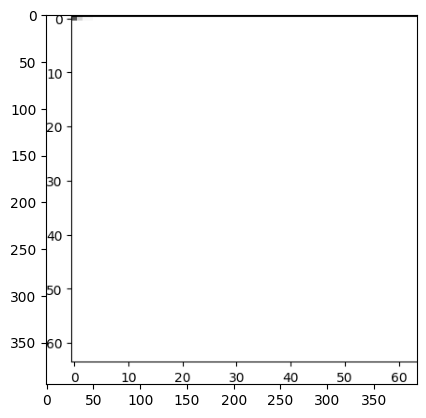

In [ ]:
from PIL import Image
img = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/code/IGTD/test2/data/_10000_image.png'
img = Image.open(img)
print(img.size)
plt.imshow(img)

(64, 64)


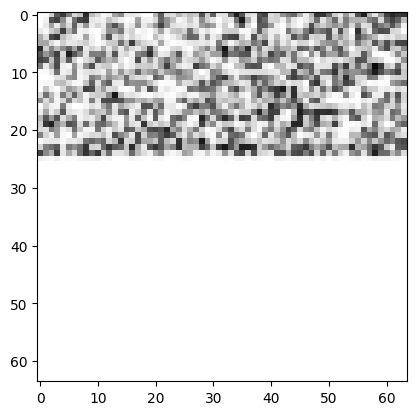

In [ ]:
img_resized = img.resize((64,64))
print(img_resized.size)
plt.imshow(img_resized)
plt.grid(False)

In [ ]:
obj = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/code/IGTD/test/test1/Results.pkl'
objects = []
with (open(obj, "rb")) as openfile:
    while True:
        try:
            objects.append(cp.load(openfile))
        except EOFError:
            break

In [ ]:
objects[0]

,A2ML1,ABCA3,ABCC3,ABO,ACP5,ACSL5,ADAM8,ADAMTS1,ADM,ADM2,...,VIM,WFDC2,WNK4,WNT5A,YBX2,ZBED2,ZG16B,ZNF703,ZNF750,ZNF853
CCL_100,0.004091,0.584926,0.831278,0.603603,0.014991,0.951504,0.586766,0.004407,0.368580,0.706956,...,0.796291,0.823980,0.742799,0.000000,0.068633,0.503608,0.982094,0.696504,0.011548,0.007984
CCL_1000,0.031288,0.841432,0.369475,0.013115,0.085299,0.015608,0.223864,0.013383,0.564680,0.563872,...,0.055929,0.025829,0.375632,0.020670,0.923539,0.001654,0.738126,0.633798,0.428559,0.205988
CCL_1001,0.014950,0.036652,0.739522,0.646079,0.032655,0.932645,0.230116,0.134976,0.550398,0.351865,...,0.000000,0.031994,0.459353,0.001160,0.526670,0.488824,0.135369,0.711266,0.037850,0.011776
CCL_1002,0.000000,0.067849,0.841865,0.000000,0.014991,0.484329,0.147886,0.509385,0.997803,0.005190,...,0.850321,0.031994,0.115544,0.878004,0.010668,0.019586,0.070795,0.494922,0.006622,0.548303
CCL_1003,0.000000,0.017647,0.072094,0.000000,0.351307,0.555456,0.282211,0.056471,0.150233,0.032726,...,0.568487,0.051658,0.017348,0.014918,0.015238,0.174242,0.004723,0.008030,0.102222,0.312774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCL_127,0.004091,0.137039,0.018922,0.000000,0.713655,0.005173,0.080884,0.534846,0.770667,0.427664,...,0.937208,0.019664,0.719572,0.053870,0.091571,0.045599,0.009457,0.309046,0.024712,0.007984
CCL_129,0.008155,0.371726,0.022452,0.000000,0.187217,0.603592,0.412368,0.022360,0.095303,0.962346,...,0.042786,0.044218,0.144452,0.058512,0.108320,0.026100,0.124289,0.123170,0.029683,0.085230
CCL_130,0.062531,0.893900,0.037795,0.000000,0.074840,0.032420,0.118873,0.245144,0.199121,0.760162,...,0.762704,0.045387,0.410275,0.425825,0.551247,0.009793,0.039348,0.966344,0.009924,0.831337
CCL_131,0.001352,0.185842,0.747252,0.034353,0.168390,0.382128,0.155580,0.571242,0.537215,0.377896,...,0.859083,0.014668,0.252805,0.073595,0.036665,0.215084,0.066095,0.437766,0.011548,0.110778


In [ ]:
image_array = objects[1]
# Check the shape of the array
print("Shape of the array:", image_array.shape)

# Iterate through the images
for i in range(image_array.shape[2]):
    # Access the i-th image
    current_image = image_array[:, :, i]
    print(f"\nPixel values of the first row in image {i + 1}:\n\n", current_image[0, :])
    print(f"\nPixel values of the first column in image {i + 1}:\n\n", current_image[:, 0])

specific_image = image_array[:, :, 0]  # Access the first image

In [ ]:
original_tab_data = objects[0]
generated_img_data = objects[1]
sample_names = objects[2]

mapping_dict = {}

for i in range(len(sample_names)):
    sample_name = sample_names[i]
    image_data = generated_img_data[:,:,i]

    mapping_dict[sample_name] = {
        'image_data':image_data
    }

In [ ]:
for key, values in mapping_dict.items():
    print(f'key: {key}\n, values:{values}')

Streaming output truncated to the last 5000 lines.
         63.11810181, 122.2184329 , 100.61486236,   1.75688981,
        135.55128217, 202.6256984 ,  36.47861918,  42.70327389,
        166.57145466,  82.60029731, 191.5790708 , 167.79199439,
        151.18577062,  14.16666662],
       [200.69205907, 116.00269177,   2.46755745, 114.42147243,
        152.2848949 , 144.87734832,   1.8295966 , 190.61138501,
        157.82134959, 132.39019489,  91.75300829,  94.64199515,
         89.74924688, 160.60906524, 149.39030641, 154.41097729,
        164.19017274, 168.31084557,  82.03551738, 113.87430573,
        123.67847415,  41.80342444, 115.07332714,  56.12210673,
        163.4054648 , 121.19802305,  11.63498086, 143.51199743,
         33.68446011, 103.72196768],
       [149.83546402,  11.05893202, 144.63224903, 249.92957744,
         99.56046281,  84.0299573 ,   9.12487835, 220.27559792,
        156.7772112 , 178.26905056, 131.6072651 , 179.52518231,
         91.26305489, 152.46161231, 121.478